# Test the loss functions

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
# Basic
from IPython.display import display

# For OS-agnostic paths
from pathlib import Path

# Plotting
from matplotlib import pyplot as plt
import seaborn as sns
import torch
from torch import nn
import pandas as pd
import numpy as np
sns.set_style("whitegrid")
from copy import deepcopy
import glob, json
from datetime import datetime
import torch
from torch import nn

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import DataLoader, Dataset, TensorDataset


from torchinfo import summary

%cd ..

from src.utils import load_raw_data
from src.plotting import plot_pointcloud, plot_sample_figures
from src.models.HardSphereGAN import GAN, HSGenerator, HSDiscriminator
from src.models.StaticScaler import StaticMinMaxScaler

%cd -

plt.set_cmap("viridis")

/Users/veikko/Documents/GitHub/hard-spheres
/Users/veikko/Documents/GitHub/hard-spheres/Notebooks


<Figure size 640x480 with 0 Axes>

In [9]:
dataframe.describe().round(2)

,class,x,y,r
count,1052000.00,1052000.00,1052000.00,1052000.00
mean,6.53,-0.00,0.01,0.99
std,5.11,12.56,12.55,0.24
min,1.00,-21.75,-21.75,0.73
25%,2.00,-10.89,-10.86,0.78
50%,5.00,-0.00,0.00,0.92
75%,10.00,10.87,10.87,1.15
max,20.00,21.75,21.75,1.62


In [12]:

phis = [0.86] # Add more phis here

path = Path("../data/raw/samples")


files, dataframe, metadata = load_raw_data(path, phi=phis, subpath="")

dataframe.sort_index()

# Hex lattice

N = 1600 
X_box = 41.076212368516387
Y_box = 35.573043402379753   
 
# Square lattice
N = 1600
X_box = 38.225722823651111
y_box = 38.225722823651111 


# Fullscale data

N = 2000 
X_box = 21.75
Y_box = 21.75

Number of Files found :  526


In [13]:

scale_factor = max(X_box, Y_box)
# r_scale_factor = dataframe["r"].max()

scaler = StaticMinMaxScaler(
    columns = ["x", "y", "r"],
    maximum = [scale_factor, scale_factor, 2*scale_factor], # NOTE: Tuned for physical feasibility
    minimum = [-scale_factor, -scale_factor, 0] # NOTE: Tuned for physical feasibility
)

dataframe_scaled = pd.DataFrame(scaler.transform(dataframe.copy()), columns=dataframe.columns)

dataframe_scaled.set_index(dataframe.index, inplace=True)

dataframe_scaled = dataframe_scaled.drop(columns=["class"]) # Redundant with r
# dataframe_scaled = dataframe_scaled.sort_values(by=["experiment", "sample"])
dataframe_scaled.describe().round(2)

,x,y,r
count,1052000.00,1052000.00,1052000.00
mean,0.50,0.50,0.02
std,0.29,0.29,0.01
min,0.00,0.00,0.02
25%,0.25,0.25,0.02
50%,0.50,0.50,0.02
75%,0.75,0.75,0.03
max,1.00,1.00,0.04


Creating Dataset
Descriptor List:  ['phi']


/Users/veikko/Documents/GitHub/hard-spheres/src/HSDataset.py:31: PerformanceWarning: indexing past lexsort depth may impact performance.
  dataframe.loc[(experiment, sample), :].copy().values,


torch.Size([526, 1, 1])
torch.Size([526, 2000, 3])


<Axes: >

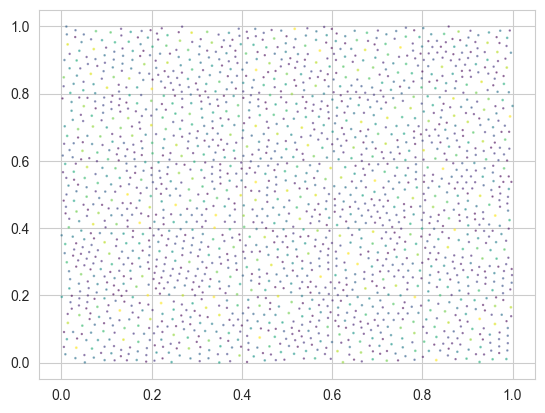

In [14]:
## Build dataset
from src.HSDataset import HSDataset

dataset = HSDataset(
    dataframe_scaled.copy(), # Dont use the ordering
    descriptor_list=["phi"],
    synthetic_samples={"rotational": 0, "shuffling": 0}, 
    downsample=False
    )
print(dataset[:][0].shape)
print(dataset[:][1].shape)
# Create a function that visualizes the point cloud

plot_pointcloud(dataset[2][1], plot_radius=True)

# Test different components of loss functions

In [15]:
from src.models.losses import HSGeneratorLoss

lfn = HSGeneratorLoss(
    **{
            "radius_loss": 0,
            "grid_density_loss": 1,
            "gan_loss": 1,
            "distance_loss": 1,
            "physical_feasibility_loss": 1,
            "coefficients":{
                "gan_loss": 1,
                "radius_loss": 1,
                "grid_density_loss": 50,
                "physical_feasibility_loss": 100,
                "distance_loss": 100,
            },
        }
)

### Feasibility loss

In [16]:
dataframe_scaled
dataframe.drop(columns=["class"])

x          y         r
experiment sample                                    
phi-0.86   sample-245 -21.345870 -15.024694  0.730000
           sample-245  20.038204 -19.199467  0.776842
           sample-245 -19.955206 -14.443004  0.823684
           sample-245 -13.669206 -10.131996  0.964211
           sample-245  -9.936614  -7.810038  0.870526
...                          ...        ...       ...
           sample-468  15.738703 -21.721624  0.776842
           sample-468 -19.316748 -18.640416  0.823684
           sample-468  21.513569 -16.596960  1.151579
           sample-468 -17.922827 -19.644332  0.870526
           sample-468 -20.417054 -13.410191  0.964211

[1052000 rows x 3 columns]

Creating Dataset
Descriptor List:  ['phi']


/Users/veikko/Documents/GitHub/hard-spheres/src/HSDataset.py:31: PerformanceWarning: indexing past lexsort depth may impact performance.
  dataframe.loc[(experiment, sample), :].copy().values,


Feasibility loss tensor(246604.2344)


tensor(60.4162)

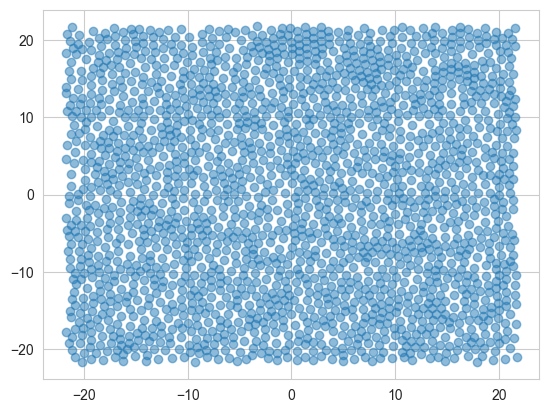

In [17]:
dataset = HSDataset(
    # dataframe_scaled.copy(), # Dont use the ordering
    dataframe.drop(columns=["class"]),
    descriptor_list=["phi"],
    synthetic_samples={"rotational": 0, "shuffling": 0}, 
    downsample=False
    )

batch_size = 32

sample_x = dataset.x[0:batch_size]
sample_y = dataset.y[0:batch_size]

plot_pointcloud(sample_y[0], plot_radius=False)

print("Feasibility loss", lfn._physical_feasibility_loss(sample_y))

# Feasibility loss should be zero right?

from torch import cdist

dist = cdist(sample_y[0][:, :2], sample_y[0][:, :2])

# Set the diagonal to zero

# dist[dist == 0] = 0.1 # Set to some value, we are interested in min and max

dist.max()

The loss is very small, as it should be.



Next set points to overlap on purpose.

Creating Dataset
Descriptor List:  ['phi']


/Users/veikko/Documents/GitHub/hard-spheres/src/HSDataset.py:31: PerformanceWarning: indexing past lexsort depth may impact performance.
  dataframe.loc[(experiment, sample), :].copy().values,


Feasibility loss tensor(246604.2344)


tensor(0.0007)

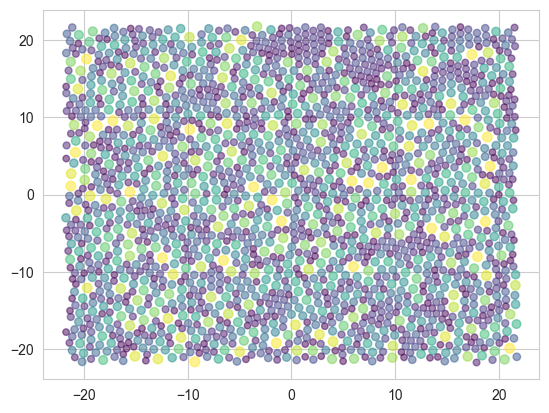

In [18]:
batch_size = 32

dataset = HSDataset(
    # dataframe_scaled.copy(), # Dont use the ordering
    dataframe.drop(columns=["class"]),
    descriptor_list=["phi"],
    synthetic_samples={"rotational": 0, "shuffling": 0}, 
    downsample=False
    )


sample_x = dataset.x[0:batch_size]
sample_y = dataset.y[0:batch_size]

# Set points to overlap
points = 2

# sample_y[0][:points,0:2] = torch.FloatTensor([1,1])# + torch.randn((points,2))*0.01

plot_pointcloud(sample_y[0], plot_radius=True)

print("Feasibility loss", lfn._physical_feasibility_loss(sample_y))

# Feasibility loss should be zero right?

from torch import cdist

dist = cdist(sample_y[0][:, :2], sample_y[0][:, :2])

# Set the diagonal to zero
dist = dist.tril(diagonal=0) 
dist = dist[~np.isclose(dist, 0)] # Set to some value, we are interested in min and max

dist.min()

In [52]:
r = torch.from_numpy(dataframe.query("sample=='sample-78'")[["r"]].values).unsqueeze(0)
r = (r.squeeze(0).T + r).squeeze(0)
r

tensor([[1.8347, 1.6942, 1.6474,  ..., 2.0689, 1.7879, 2.3032],
        [1.6942, 1.5537, 1.5068,  ..., 1.9284, 1.6474, 2.1626],
        [1.6474, 1.5068, 1.4600,  ..., 1.8816, 1.6005, 2.1158],
        ...,
        [2.0689, 1.9284, 1.8816,  ..., 2.3032, 2.0221, 2.5374],
        [1.7879, 1.6474, 1.6005,  ..., 2.0221, 1.7411, 2.2563],
        [2.3032, 2.1626, 2.1158,  ..., 2.5374, 2.2563, 2.7716]],
       dtype=torch.float64)

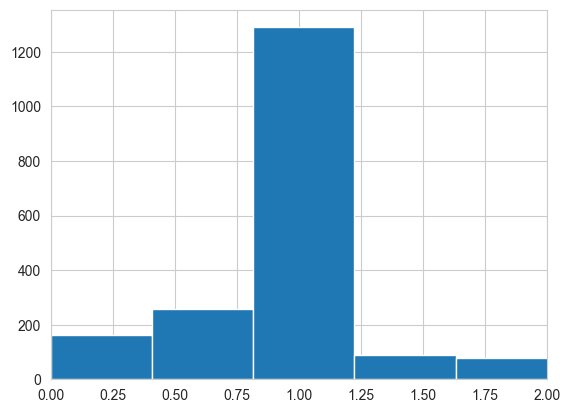

In [102]:
xy = torch.from_numpy(dataframe.query("sample=='sample-78'")[["x","y"]].values)

dist = cdist(xy[:, :2], xy[:, :2])

r_raw = torch.from_numpy(dataframe.query("sample=='sample-78'")[["r"]].values).unsqueeze(0)
r = (r_raw.squeeze(0).T + r_raw).squeeze(0)

# Set the diagonal to zero
dist = dist.tril(diagonal=0) 

# Find nearest neighbour
dist[dist == 0] = torch.inf

plt.hist(dist.min(dim=0).values[:-1], bins=100)
plt.xlim(0,2)
plt.show()
# Smallest distance between two points is 0.5, so our radius should be 0.5
# Anomalies exist closer to zero

In [112]:
overlap_distance = r - dist
overlap_distance = overlap_distance.squeeze(0)

overlap_distance = nn.ReLU(inplace=False)(
    overlap_distance
)  # Zero the negative values, the distances can be larger than radius

overlap_distance[:8, :8]

tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]], dtype=torch.float64)

In [113]:
(overlap_distance.numpy() > 0).sum()

12235

(array([4184., 1931., 3049., 2600.,  348.,   58.,   29.,   21.,    7.,
           8.]),
 array([8.24136427e-05, 3.24074139e-01, 6.48065863e-01, 9.72057588e-01,
        1.29604931e+00, 1.62004104e+00, 1.94403276e+00, 2.26802449e+00,
        2.59201621e+00, 2.91600794e+00, 3.23999966e+00]),
 <BarContainer object of 10 artists>)

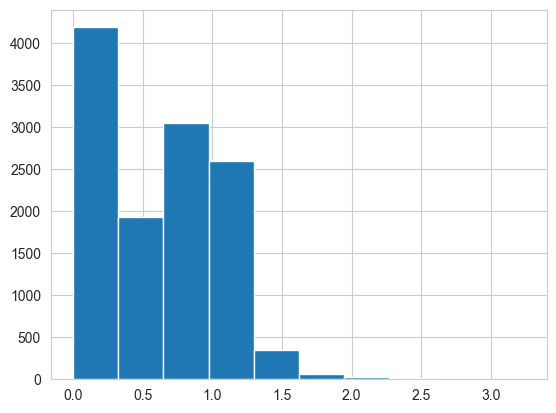

In [114]:
plt.hist(overlap_distance[overlap_distance > 0].numpy()) # NOTE: Tolerance to the radius

In [117]:
(2*r_raw).mean()

tensor(1.9784, dtype=torch.float64)

In [58]:
dist

tensor([[    inf,     inf,     inf,  ...,     inf,     inf,     inf],
        [17.6832,     inf,     inf,  ...,     inf,     inf,     inf],
        [16.6637,  2.9879,     inf,  ...,     inf,     inf,     inf],
        ...,
        [39.2627, 21.9363, 22.6019,  ...,     inf,     inf,     inf],
        [10.2692, 19.2990, 19.9000,  ..., 40.8163,     inf,     inf],
        [ 2.2890, 19.7429, 18.8533,  ..., 41.4354,  9.7188,     inf]],
       dtype=torch.float64)

In [64]:
xy

tensor([[-18.4572,  -9.8750],
        [ -1.7885, -15.7782],
        [ -2.0526, -12.8019],
        ...,
        [ 20.0937, -17.3170],
        [-20.6401, -19.9095],
        [-20.7243, -10.1910]], dtype=torch.float64)

In [65]:
torch.sqrt((xy[0,0] - xy[-1,0])**2 + (xy[0,1] - xy[-1,1])**2)

tensor(2.2890, dtype=torch.float64)

In [70]:
r_raw[0,0,0] + r_raw[0,-2,0]

tensor(1.7879, dtype=torch.float64)